<a href="https://colab.research.google.com/github/LilySu/DS-Unit-2-Sprint-3-Classification-Validation/blob/master/LS_DS_232_Baselines_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd 

url = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Sprint-3-Classification-Validation/master/module2-baselines-validation/weather-normal-il.csv'
weather = pd.read_csv(url, parse_dates=['DATE']).set_index('DATE')
# weather['2014-05':'2019-05'].plot(y='TMAX')
# plt.title('Daily high temperature in Normal, IL');

In [45]:
weather.head()

,STATION,LATITUDE,LONGITUDE,PRCP,TMAX,TMIN
DATE,,,,,,
1945-03-30,USC00110766,40.51667,-89.0,0.00,64.0,37.0
1945-03-31,USC00110766,40.51667,-89.0,0.31,68.0,38.0
1945-04-01,USC00110766,40.51667,-89.0,0.00,68.0,50.0
1945-04-02,USC00110766,40.51667,-89.0,1.01,62.0,49.0
1945-04-03,USC00110766,40.51667,-89.0,0.00,58.0,39.0


In [46]:
weather['TMIN'].max()

86.0

In [47]:
weather.shape

(26651, 6)

In [48]:
from sklearn.metrics import mean_absolute_error
predicted = [weather['TMIN'].mean()] * len(weather)
mean_absolute_error(weather['TMIN'], predicted)

16.467622280714586

In [49]:
weather['TMIN_yesterday'] = weather.TMIN.shift(1)
weather = weather.dropna()
mean_absolute_error(weather.TMIN, weather.TMIN_yesterday)

5.988405253283302

In [0]:
def above55(row):
    if row['TMIN'] >= 55:
        val = 'y'
    else:
        val = 'n'
    return val

weather['above55']=weather.apply(above55, axis=1)

In [0]:
test = weather['above55'] == 'y'

In [82]:
weather.head()

,STATION,LATITUDE,LONGITUDE,PRCP,TMAX,TMIN,TMIN_yesterday,above55
DATE,,,,,,,,
1945-03-31,USC00110766,40.51667,-89.0,0.31,68.0,38.0,37.0,n
1945-04-01,USC00110766,40.51667,-89.0,0.00,68.0,50.0,38.0,n
1945-04-02,USC00110766,40.51667,-89.0,1.01,62.0,49.0,50.0,n
1945-04-03,USC00110766,40.51667,-89.0,0.00,58.0,39.0,49.0,n
1945-04-04,USC00110766,40.51667,-89.0,0.13,63.0,36.0,39.0,n


In [83]:
weather['above55'].value_counts()

n    18223
y     8427
Name: above55, dtype: int64

In [0]:
X = weather.drop(columns='above55')
y = weather['above55'] =='y'

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [0]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42)

In [87]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((14924, 7), (6396, 7), (5330, 7), (14924,), (6396,), (5330,))

In [88]:
y_train.value_counts(normalize=True)

False    0.684401
True     0.315599
Name: above55, dtype: float64

In [0]:
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_val)

In [90]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred)# there isn't really a majority class, similar temperatures occur 2% time

0.6823014383989994

In [101]:
X_train_numeric = X_train.select_dtypes('number')
X_val_numeric   = X_val.select_dtypes('number')

from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=2)
tree.fit(X_train_numeric, y_train)
y_pred_proba = tree.predict_proba(X_val_numeric)[:,1]
roc_auc_score(y_val, y_pred_proba)

1.0

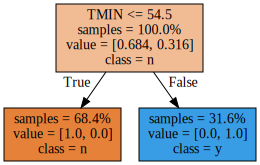

In [102]:

import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree, out_file=None, feature_names=X_train_numeric.columns, class_names=['n', 'y'], filled=True, impurity=False, proportion=True)

graphviz.Source(dot_data)

In [103]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train_numeric, y_train)
y_pred_proba = model.predict_proba(X_val_numeric)[:,1]
roc_auc_score(y_val, y_pred_proba)

1.0

In [0]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [105]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_val_scaled   = scaler.transform(X_val_numeric)

model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train_scaled, y_train)
y_pred_proba = model.predict_proba(X_val_scaled)[:,1]
roc_auc_score(y_val, y_pred_proba)

0.9999950381431468

In [106]:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    StandardScaler(), 
    LogisticRegression(solver='lbfgs', max_iter=1000)
)

pipeline.fit(X_train_numeric, y_train)
y_pred_proba = pipeline.predict_proba(X_val_numeric)[:,1]
roc_auc_score(y_val, y_pred_proba)

0.9999950381431468

In [107]:
# Imports
%matplotlib inline
import warnings
import category_encoders as ce
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.exceptions import DataConversionWarning
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Load data
bank = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

# Assign to X, y
X = weather.drop(columns='above55')
y = weather['above55'] == 'y'

# Split Train, Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Make pipeline
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    StandardScaler(), 
    LogisticRegression(solver='lbfgs', max_iter=1000)
)

# Cross-validate with training data
scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=10, 
                         n_jobs=-1, verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.6s finished


In [108]:
print('Cross-Validation ROC AUC scores:', scores)
print('Average:', scores.mean())

Cross-Validation ROC AUC scores: [0.99999594 1.         0.99999796 0.99997456 0.99994607 0.99999288
 1.         0.99999796 1.         1.        ]
Average: 0.9999905368035892


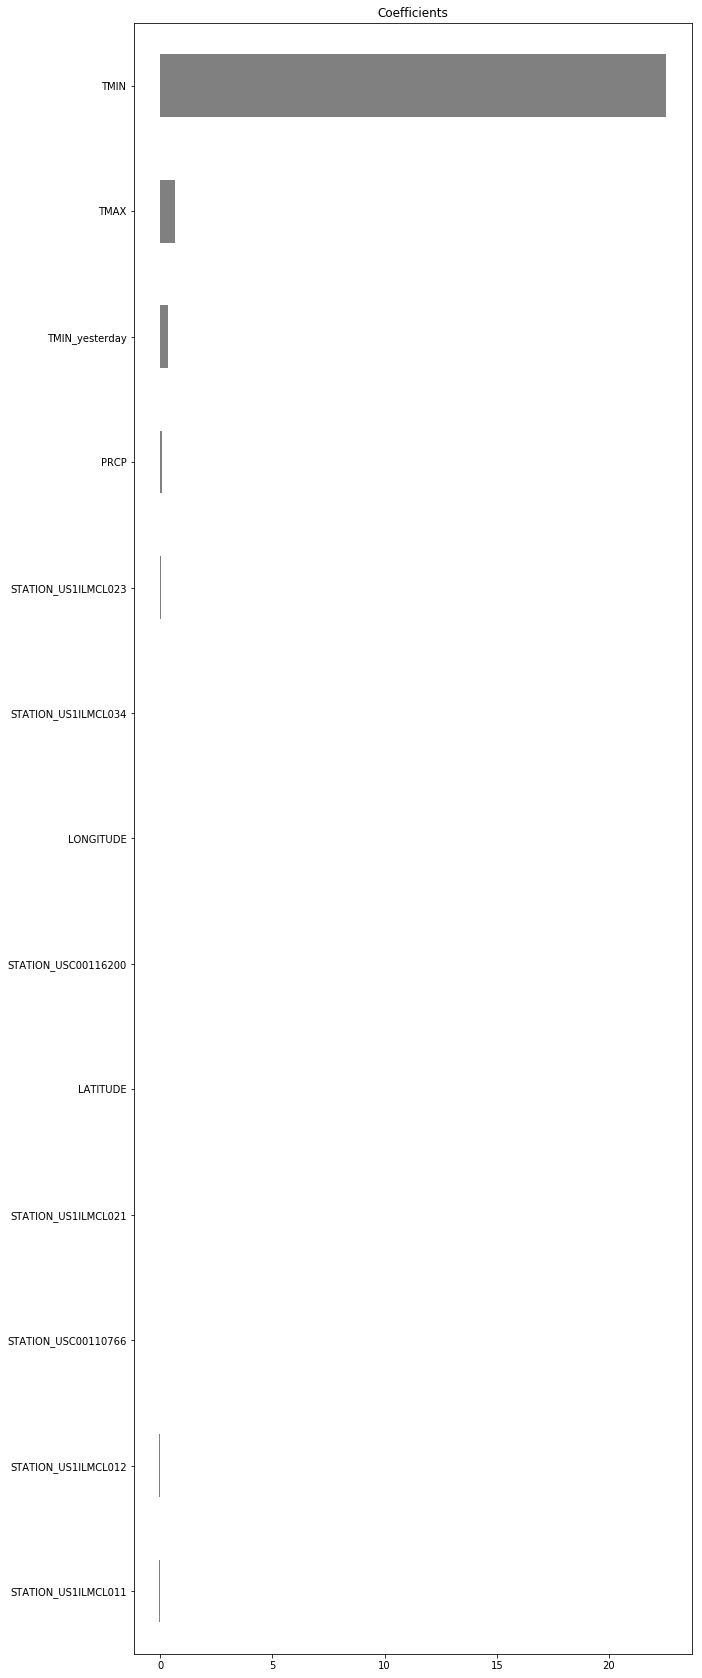

In [109]:
# (Re)fit on training data
pipeline.fit(X_train, y_train)

# Visualize coefficients
plt.figure(figsize=(10,30))
plt.title('Coefficients')
coefficients = pipeline.named_steps['logisticregression'].coef_[0]
feature_names = pipeline.named_steps['onehotencoder'].transform(X_train).columns
pd.Series(coefficients, feature_names).sort_values().plot.barh(color='gray');